In [17]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from tqdm.auto import tqdm, trange
import matplotlib as mpl
from scipy.sparse import csr_matrix
from scipy.integrate import quad
import numba

sys.path.append('../Numerical_methods')
from bachelor_funcs import analytic_green
from matrix_calculator import A_matrix
from bachelor_funcs import color_use
from ODE_schemes import stencil_calc

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}
mpl.rc('font', **font)

In [18]:
N = 300
r_i = 0.01
r_f = 60
r = np.logspace(np.log10(r_i), np.log10(r_f), N)
print(r[0] - np.diff(r)[0])

γ = 1
t_s = (3 * (2 - γ)**2)**(-1)
print(t_s)

t_func = lambda T, ts: (T - 1) * ts
T_func = lambda t, ts: t / ts + 1
T_plot = np.array([1, 2, 4, 8])
t_func(T_plot, t_s)

0.009704772276558084
0.3333333333333333


array([0.        , 0.33333333, 1.        , 2.33333333])

In [19]:
# Inital surface density:
def Σ_initial(x, γ = 1):
    return (3 * np.pi * x**γ)**(-1) * np.exp(-x**(2 - γ))

C = 1 / quad(Σ_initial, r_i, r_f)[0]

def Σ_initial_norm(x, γ = 1):
    return C * Σ_initial(x, γ)

# Analytical soltuion:
def Σ(r, T, γ = 1):
    not_norm = lambda r : (3 * np.pi * r**γ)**(-1) * T**(-(5/2 - γ) / (2 - γ)) * np.exp(-r**(2 - γ) / T)
    #C = 1 / quad(not_norm, x_i, x_f)[0]
    return C * not_norm(r)

# No boundary condtions

In [20]:
s = 3

i1 = 0
i2 = s
A = np.zeros((N, N))
for i in range(N):
    if abs(i1 - i) >= s/2 and i2 < N:
        i1 += 1
        i2 += 1

    stencil = r[i1:i2] - r[i]
    coeff = stencil_calc(stencil, 1)
    A[i, i1:i2] = coeff
A_log = csr_matrix(A.copy())

In [21]:
def Σ_step(Σ, Δ_t):
    inner = Σ * r**(3/2)

    step = (3 / r) * (A_log @ (r**(1/2)  * (A_log @ inner)))
    return Σ + Δ_t * step

4.391784512492663e-08 1.2842103595555307e-06


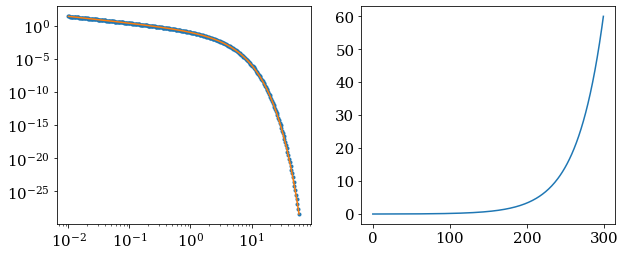

In [22]:
fig, axs = plt.subplots(1,2, figsize= (10, 4))
Σ0 = Σ_initial_norm(r)
Δt = 1e-10

res = Σ_step(Σ0, Δt)
axs[0].loglog(r, Σ0, '.')
axs[0].loglog(r, res)

axs[1].plot(r)
δΣ = np.linalg.norm(res[r <=1e1] - Σ0[r <= 1e1])
print(δΣ, np.min(np.abs(Σ0[r <= 1e1])))

In [23]:
Σ0 = Σ_initial_norm(r)
sol = []
Δt_solved = []
t_solved = []

Δt = 1e-6
rejected = 0
step = 0
t = 0
ε_rel=1e-1
ε_abs=1e-2
error_area = 1e1

while t <= t_func(T_plot[-1], t_s):
    res = Σ_step(Σ0, Δt)

    δΣ = np.linalg.norm(res - Σ0) / np.linalg.norm(Σ0)
    ε_tol = ε_rel

    if δΣ == 0:
        Δt_next = 1.2 * Δt
    else:
        Δt_next =  0.95*(ε_tol/δΣ) * Δt
        if Δt_next > 1.2 * Δt:
            Δt_next = 1.2 * Δt
        if Δt_next < 0.8 * Δt:
            Δt_next = 0.8 * Δt 
    

    if any(np.isnan(res)) == True:
        break

    if δΣ <= ε_tol:
        t += Δt
        step += 1
        sol.append(res)
        Σ0 = res
        Δt_solved.append(Δt)
        t_solved.append(t)
    else:
        rejected += 1
    Δt = Δt_next   
    #if step == 2.5e4:
    #    break

In [24]:
print(len(sol), rejected)

323460 163843


In [25]:
i_t = []
for T in T_plot:
    i_t.append(np.argmin(abs(T_func(np.asarray(t_solved), t_s) - T)))
i_t

[0, 46166, 138588, 323458]

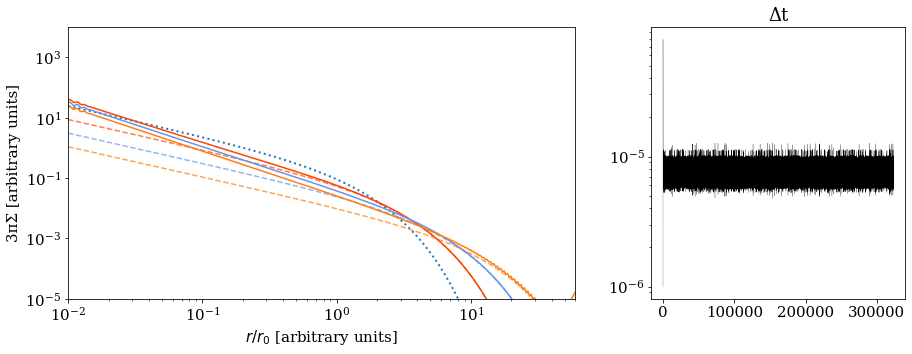

In [26]:
fig, axs = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].set(xlabel='$r/r_0$ [arbitrary units]', ylabel='3πΣ [arbitrary units]', ylim = (1e-5, 1e4), xlim = (r_i, r_f))
axs[0].loglog(r, Σ_initial_norm(r), ls=':', lw = 2)
for i, col in zip(i_t[1:], color_use):
    axs[0].plot(r, sol[i], label = f'T = {t_solved[i] * 12:1.3f}', c = col)
    axs[0].loglog(r, Σ(r, T_func(np.asarray(t_solved)[i], t_s)), c = col, ls='--', alpha = 0.7)

axs[1].set(title = 'Δt')
axs[1].semilogy(Δt_solved, '-', lw=0.2, c = 'black')

# With boundary condtions $\partial_r(\Sigma r^{3/2})=0$ at $r_{in}$

In [27]:
Δr = np.diff(r)
r_ghost = np.concatenate((np.array([r[0] - Δr[0]]), r, np.array([r[-1] + Δr[-1]])))
Δr[-5:]

array([1.53154091, 1.57675624, 1.62330646, 1.67123096, 1.72057033])

In [28]:
s = 3

i1 = 0
i2 = s
A_ghost = np.zeros((N + 2, N + 2))
for i in range(N + 2):
    if abs(i1 - i) >= s/2 and i2 < N:
        i1 += 1
        i2 += 1

    stencil = r_ghost[i1:i2] - r_ghost[i]
    coeff = stencil_calc(stencil, 1)
    A_ghost[i, i1:i2] = coeff
sA_ghost = csr_matrix(A_ghost.copy())

In [29]:
def Σ_step_ghost(Σ, Δ_t):
    inner = Σ * r**(3/2)
    ghost_i = np.array([inner[1]])
    ghost_f = np.array([inner[-2]])

    inner_ghost = np.concatenate((ghost_i, inner, ghost_f))
    step = (3/r_ghost) * A_ghost @ (r_ghost**(1/2) * (A_ghost @ inner_ghost))

    return Σ + Δ_t * step[1 : -1]

In [30]:
Σ0 = Σ_initial_norm(r)
sol = []
Δt_solved = []
t_solved = []

Δt = 1e-6
rejected = 0
t = 0
ε_rel=1e-1
ε_abs=1e-2
error_area = 1e1

while t < t_func(T_plot[-1], t_s):
    res = Σ_step_ghost(Σ0, Δt)

    δΣ = np.linalg.norm(res - Σ0) / np.linalg.norm(Σ0)
    ε_tol = ε_rel

    Δt_next =  0.95*(ε_tol/δΣ) * Δt
    if Δt_next > 1.2 * Δt:
        Δt_next = 1.2 * Δt
    if Δt_next < 0.8 * Δt:
        Δt_next = 0.8 * Δt 
    
    if any(np.isnan(res)) == True:
        break

    if δΣ <= ε_tol:
        t += Δt
        sol.append(res)
        Σ0 = res
        Δt_solved.append(Δt)
        t_solved.append(t)
    else:
        rejected += 1    
    Δt = Δt_next 

In [31]:
i_t = []
for τ in T_plot:
    i_t.append(np.argmin(abs(τ - np.asarray(t_solved) * 12)))
i_t

[18560, 37124, 74234, 148455]

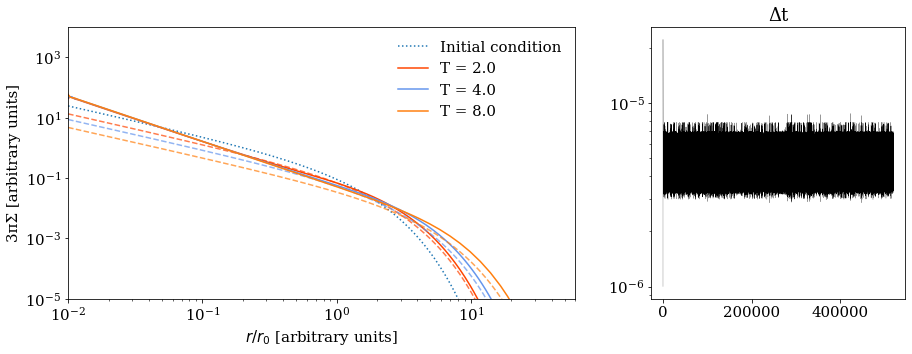

In [32]:
fig, axs = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].set(xlabel='$r/r_0$ [arbitrary units]', ylabel='3πΣ [arbitrary units]', ylim = (1e-5, 1e4), xlim = (r_i, r_f))
axs[0].loglog(r, Σ_initial_norm(r), ls=':', label = 'Initial condition')

for i, col in zip(i_t[1:], color_use):
    axs[0].loglog(r, sol[i], label = f'T = {t_solved[i] * 12:1.1f}', c = col)
    axs[0].loglog(r, Σ(r, T_func(np.asarray(t_solved)[i], t_s)), c = col, ls='--', alpha = 0.7)
axs[0].legend(frameon = False)

axs[1].set(title = 'Δt')
axs[1].semilogy(Δt_solved, '-', lw=0.2, c = 'black')